<a href="https://colab.research.google.com/github/gamadi22/Astronomy/blob/main/Galaxy10_Denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.14


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Autoencoder convolucional para denotar imágenes de galaxias

En esta sencilla demostración, construiremos un autocodificador convolucional diseñado específicamente para denotar un conjunto de imágenes de galaxias con las mismas dimensiones. Los autocodificadores son un tipo de red neuronal artificial (RNA) diseñada para recoger patrones comunes de los datos de entrenamiento de entrada con el fin de refinar y validar intentando replicar la entrada. El tipo de RNA que vamos a utilizar es la red neuronal convolucional (CNN), que es más adecuada para las imágenes en color que las habituales capas densas. Así, la combinación de estos tipos de redes neuronales nos dará un **autoencoder convolucional**.

#### Preliminares

- generar directorios de archivos para nuestro almacenamiento de entrada y salida. 

In [ ]:
import os

In [ ]:
try:
    os.makedirs('Data//Input')
except OSError:
    pass

try:
    os.makedirs('Data//Output//DataFrame')
except OSError:
    pass

try:
    os.makedirs('Data//Output//Models')
except OSError:
    pass

try:
    os.makedirs('Data//Output//Plots//Individual')
except OSError:
    pass

# I. Descargamos [Galaxy10 SDSS](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) dataset de [`AstroNN`](https://astronn.readthedocs.io/en/latest/)

&emsp;

- AstroNN:


<div>
<img src="https://astronn.readthedocs.io/en/latest/_images/galaxy10sdss_example.png" width="800"/>
</div>

<blockquote>
    Galaxy10 SDSS is a dataset que contiene imágenes de galaxias 21785 69x69 pixels (g, r and i band) separadas en 10 clases. Galaxy10 SDSS las imágenes proceden de <a href="http://www.sdss.org/" >Sloan Digital Sky Survey</a> y las etiquetas proceden de <a href="https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/" >Galaxy Zoo</a>.
</blockquote> **texto en negrita**

- Podemos importar el conjunto de datos SDSS galaxy10 utilizando AstroNN de la siguiente manera:

In [ ]:
pip install astroNN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 4.0 MB/s 
     |████████████████████████████████| 4.5 MB 41.8 MB/s 
     |████████████████████████████████| 832 kB 62.7 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
     |████████████████████████████████| 4.0 MB 41.7 MB/s 
  Created wheel for astroNN: filename=astroNN-1.0.1-py3-none-any.whl size=9284595 sha256=a08b06c116a44608a21cf5aa489cd913315fc4f0c87bcb117f66f7f01504e2e5
  Stored in directory: /root/.cache/pip/wheels/26/a4/7e/4cbf2a7f9cd51929da9d09345e8cd37c647b54825a1314dd2d
Successfully built astroNN


In [ ]:
from astroNN.datasets import load_galaxy10

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [ ]:
images, labels = load_galaxy10()

Galaxy10.h5:  98%|█████████▊| 207M/210M [00:04<00:00, 75.7MB/s]

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10.h5


Galaxy10.h5: 210MB [00:04, 42.5MB/s]                           


- Dividir el conjunto de datos de imágenes utilizando `train_test_split` de sklearn. 
- Sólo utilizaremos los datos de las imágenes, ya que no estamos construyendo un algoritmo de clasificación.
- Esto significa que sólo necesitaremos `train_images` y `test_images`.
- Generalmente queremos tener más datos de entrenamiento que de prueba.
- Más adelante añadiremos algo de ruido en ambos conjuntos.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
np.random.seed(42069)
train_idx, test_idx = train_test_split(np.arange(labels.shape[0]), 
                                       test_size=0.1)

train_images, train_labels = images[train_idx], labels[train_idx]
test_images, test_labels = images[test_idx], labels[test_idx]

- Cada imagen está representada por un array numpy que contiene valores de 0 a 255.
- Dividimos los datos de cada imagen, y a su vez cada elemento del array, por 255 para limitar el rango de valores de 0 a 1.
- Esto se llama normalización del rango de valores de 0 a 1. Hacemos esto para que los cálculos sean más rápidos, ayudando a nuestro autocodificador a aprender más eficientemente.

In [ ]:
train_images, test_images = train_images/255, test_images/255

- Al comprobar la forma de `train_images` y `test_images`, podemos ver que tenemos casi 20.000 datos de entrenamiento y más de 2.000 datos de prueba. 
- También podemos ver que las imágenes tienen unas dimensiones de 69x69 y tienen 3 canales, lo que significa que están coloreadas.

In [ ]:
train_images.shape

(19606, 69, 69, 3)

In [ ]:
test_images.shape

(2179, 69, 69, 3)

# II. Añadir ruido gaussiano a las imágenes

- Podemos utilizar `GaussianNoise` de TensorFlow para añadir ruido artificial a nuestros datos de imagen.
- El ruido puede aparecer en los datos de imagen recogidos por varios instrumentos, especialmente en las cámaras CCD (charged-coupled device).
- Estos son causados por algunas perturbaciones en el circuito del CCD desde su entorno. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise

- Podemos añadir un leve ruido gaussiano de 0,2 a `imágenes_de_entrenamiento` para producir una matriz separada de imágenes llamada `imágenes_de_entrenamiento_ruido`.

In [ ]:
tf.random.set_seed(420)
sample = GaussianNoise(0.2)

noisy_train_images = sample(train_images, training=True)
noisy_test_images = sample(test_images, training=True)

- Recortamos las imágenes ya que la adición de ruido gaussiano provocará que algunos valores de la matriz de imágenes se salgan de nuestro rango preferido de 0 a 1.

In [ ]:
noisy_train_images = np.clip(noisy_train_images, 0, 1)
noisy_test_images = np.clip(noisy_test_images, 0, 1)

- Previsualiza la primera imagen de entrenamiento y su imagen equivalente con ruido.

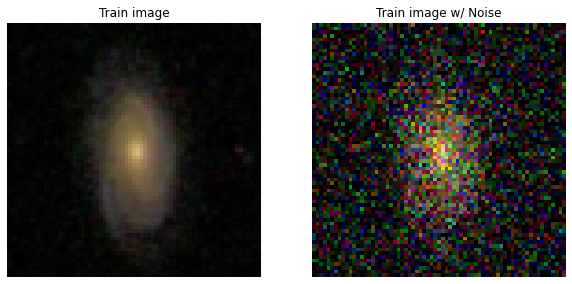

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(train_images[0])
ax[0].set(title='Train image')
ax[1].imshow(np.clip(noisy_train_images[0], 0, 1))
ax[1].set(title='Train image w/ Noise')

for axs in ax.reshape(-1):
    axs.axis(False)

# III. Preparar el autocodificador

In [ ]:
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

#### La arquitectura de nuestra red neuronal

- Los autocodificadores se componen de dos partes: el codificador y el decodificador.
    - El codificador reduce la dimensión de los datos de entrada (comprime), conservando los componentes más importantes.
    - El decodificador produce una versión ampliada de la salida del codificador (descomprime), conservando sólo los componentes importantes. 
    - Dado que el ruido no es el componente importante de estas imágenes, los autocodificadores lo eliminan, por lo que "desnotizan" las imágenes ruidosas.
- Por ahora, mi arquitectura preferida es un conjunto de capas convolucionales y de pooling máximo alternadas para los decodificadores, y un conjunto de capas convolucionales y de upsampling alternadas para el decodificador.
    - Intenté añadir más capas emparejadas tanto para el codificador como para los decodificadores y probé su resultado de entrenamiento, pero un solo par para cada uno es lo que mejor ha funcionado hasta ahora.
- La arquitectura depende de las dimensiones de las imágenes de entrada, en concreto depende el `pool_size` de `MaxPool2D` y el `size` de `UpSampling2D`. Sin embargo, la selección del número de filtros y del tamaño del núcleo es arbitraria. 
- Los 3 filtros de la última capa convolucional del `decodificador` son para los canales de color.

In [ ]:
tf.random.set_seed(420)
np.random.seed(69)


encoder = Sequential()
encoder.add(Conv2D(filters=23, kernel_size=(3,3), 
                   input_shape=(69,69,3),
                   activation='relu', padding='same'))
encoder.add(MaxPool2D(pool_size=(3, 3), padding='same'))


decoder = Sequential()
decoder.add(Conv2D(filters=23, kernel_size=(3,3), 
                   activation='relu', padding='same'))
decoder.add(UpSampling2D(size=(3, 3)))

decoder.add(Conv2D(filters=3, kernel_size=(3,3), 
                   activation='sigmoid', padding='same'))

- Combinamos el "codificador" y el "decodificador" para formar nuestro autocodificador, al que llamaremos "gal10_autocodificador".
- Para nuestro optimizador, elegimos el [algoritmo de Adam](https://keras.io/api/optimizers/adam/) y el error cuadrático medio (MSE) para la función de pérdida.
- Querríamos hacer un seguimiento de la precisión del rendimiento de nuestro autocodificador.

In [ ]:
gal10_autoencoder = Sequential([encoder, decoder])
gal10_autoencoder.compile(loss="mse", 
                          optimizer='adam', 
                          #optimizer=SGD(learning_rate=1.5), 
                          metrics=['accuracy'])

- resumen del codificador de vista previa

In [ ]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 23)        644       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 23)       0         
 )                                                               
                                                                 
Total params: 644
Trainable params: 644
Non-trainable params: 0
_________________________________________________________________


- resumen del decodificador de vista previa

In [ ]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 23, 23, 23)        4784      
                                                                 
 up_sampling2d (UpSampling2D  (None, 69, 69, 23)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 69, 69, 3)         624       
                                                                 
Total params: 5,408
Trainable params: 5,408
Non-trainable params: 0
_________________________________________________________________


- vista previa `gal10_autoencoder` resumen

In [ ]:
gal10_autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 23, 23, 23)        644       
                                                                 
 sequential_1 (Sequential)   (None, 69, 69, 3)         5408      
                                                                 
Total params: 6,052
Trainable params: 6,052
Non-trainable params: 0
_________________________________________________________________


# IV. Ejecutar el autocodificador

- En caso de que el rendimiento de `gal10_autoencoder` no mejore, podemos detener su entrenamiento mediante `early_stop`. 
- Si la pérdida de validación no disminuye después de 3 épocas, el entrenamiento se detiene.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

- Para entrenar finalmente el `gal10_autoencoder`, seleccionamos 20 epocs y un tamaño de lote de 100.
    - Entrenamos con las imágenes de entrenamiento originales y con las imágenes de entrenamiento con ruido, y luego utilizamos las imágenes de prueba originales y con ruido para la validación.
- También queremos guardar esta red entrenada para poder utilizarla en el futuro.

In [ ]:
%%time
gal10_autoencoder.fit(noisy_train_images, train_images, 
                      epochs=20, batch_size=100, 
                      #shuffle=True,
                      callbacks=[early_stop], 
                      validation_data=(noisy_test_images, test_images))

gal10_autoencoder.save('Data/Output/Models/gal10_denoiser.h5')

Epoch 1/20
197/197 [==============================] - 212s 1s/step - loss: 0.0316 - accuracy: 0.2505 - val_loss: 0.0232 - val_accuracy: 0.2569
Epoch 2/20
197/197 [==============================] - 211s 1s/step - loss: 0.0161 - accuracy: 0.4260 - val_loss: 0.0016 - val_accuracy: 0.6597
Epoch 3/20
197/197 [==============================] - 210s 1s/step - loss: 0.0012 - accuracy: 0.6699 - val_loss: 9.1385e-04 - val_accuracy: 0.6759
Epoch 4/20
197/197 [==============================] - 211s 1s/step - loss: 8.6661e-04 - accuracy: 0.6883 - val_loss: 8.0333e-04 - val_accuracy: 0.6900
Epoch 5/20
197/197 [==============================] - 207s 1s/step - loss: 7.9776e-04 - accuracy: 0.6939 - val_loss: 7.6027e-04 - val_accuracy: 0.6959
Epoch 6/20
197/197 [==============================] - 207s 1s/step - loss: 7.6599e-04 - accuracy: 0.6920 - val_loss: 7.4313e-04 - val_accuracy: 0.6882
Epoch 7/20
197/197 [==============================] - 210s 1s/step - loss: 7.4107e-04 - accuracy: 0.6852 - val_los

- Para guardar las métricas de rendimiento, guardamos el historial de `gal10_autoencoder` como `autoencoder_history`, que podemos convertir en un marco de datos para su visualización y, quizás, su posterior análisis.

In [ ]:
autoencoder_history = gal10_autoencoder.history.history

- Guardamos el marco de datos de salida y los gráficos de precisión y pérdida en sus respectivos directorios.

In [ ]:
losses_df = pd.DataFrame(autoencoder_history)
losses_df.to_csv('Data/Output/DataFrame/gal10_autoencoder_perf.csv', index=False)

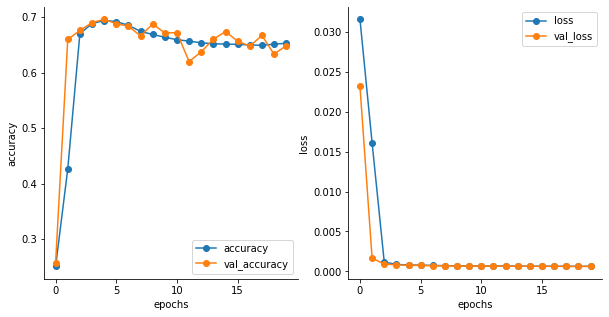

In [ ]:
losses_df = pd.DataFrame(autoencoder_history)

fig, ax = plt.subplots(1,2, figsize=(10,5))

losses_df[['accuracy','val_accuracy']].plot(ax=ax[0], marker='o')
ax[0].set(ylabel='accuracy')
losses_df[['loss','val_loss']].plot(ax=ax[1], marker='o')
ax[1].set(ylabel='loss')

for axs in ax.reshape(-1):
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.tick_params(left=True, bottom=True, 
                   labelleft=True, labelbottom=True)
    axs.set(xlabel='epochs')
    
fig.savefig('Data/Output/Plots/gal10_autoencoder_perf.png', dpi=200)

- Podemos ver que en las 5 epocs y posteriores, hay pocos cambios en nuestras métricas de entrenamiento, aparte de las pequeñas fluctuaciones en la precisión de la validación.

# V. Despliegue del Autoencoder

- Podemos desplegar los modelos guardados cargándolos. 

- Ahora podemos eliminar el ruido de las imágenes de prueba y almacenar los resultados en `denoised_images`.
- Recuerde que `gal10_autoencoder` no tiene ni idea de la

In [ ]:
%%time
denoised_images = gal10_autoencoder.predict(noisy_test_images)

CPU times: user 13.5 s, sys: 746 ms, total: 14.3 s
Wall time: 13.9 s


In [ ]:
len(denoised_images)

2179

- La eliminación del ruido de más de 2.000 imágenes se realizó en menos de 2 segundos.

- Podemos visualizar los resultados de `gal10_autoencoder` para las 6 primeras imágenes de prueba. 

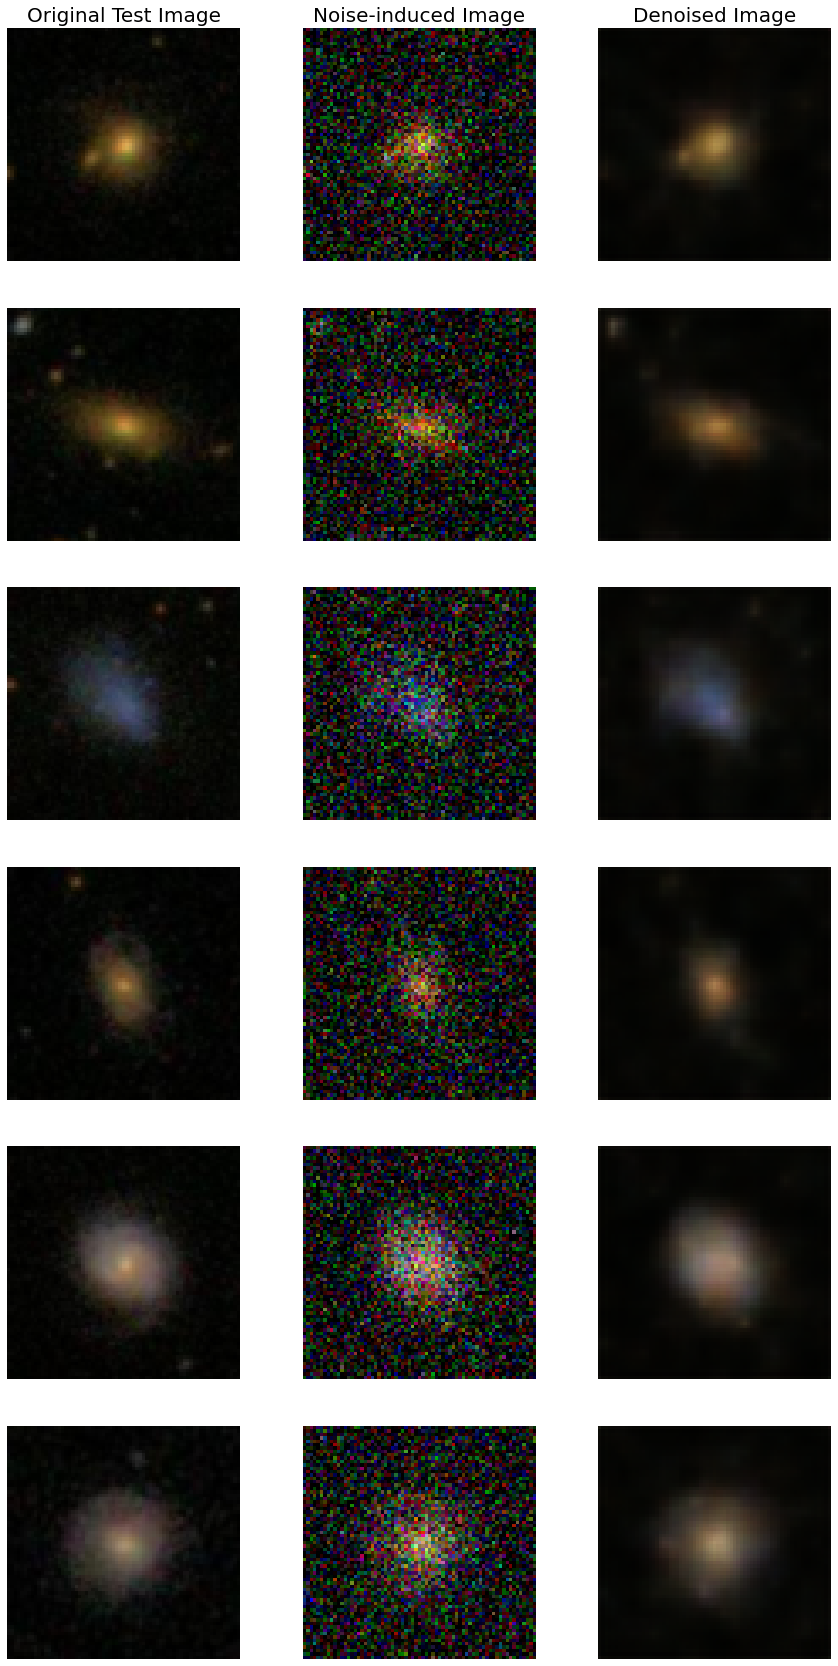

In [ ]:
n_images = 6
n_test_images = test_images[:n_images]
n_noisy_test_images = noisy_test_images[:n_images]
n_denoised_images = denoised_images[:n_images]

fig, ax = plt.subplots(n_images,3, figsize=(5*3,5*n_images))

ax[0, 0].set_title('Original Test Image', fontsize=20)
ax[0, 1].set_title('Noise-induced Image', fontsize=20)
ax[0, 2].set_title('Denoised Image', fontsize=20)
for i in range(n_images):
    
    ax[i, 0].imshow(n_test_images[i])
    ax[i, 1].imshow(n_noisy_test_images[i])
    ax[i, 2].imshow(n_denoised_images[i])

    for axs in ax.reshape(-1):
        axs.axis(False)
        axs.spines['right'].set_visible(False)
        axs.spines['top'].set_visible(False)
        axs.tick_params(left=True, bottom=True, 
                       labelleft=True, labelbottom=True)
        
fig.savefig('Data/Output/Plots/gal10_autoencoder_output_overview_gnoise_0.2.png', dpi=300)

- Podemos ver que, aunque el ruido se ha eliminado limpiamente, inevitablemente perdemos algunos detalles; la definición de los brazos de algunas galaxias y las fuentes de luz más pequeñas que las rodean se ven disminuidas. 
- Sin embargo, hemos logrado nuestro objetivo principal de preservar los objetos principales de cada una de nuestras imágenes de entrada. 

- Finalmente podemos guardar todas las salidas de `gal10_autoencoder`.

In [ ]:
%%time
for i in range(len(test_images)/10):
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    ax[0].set_title('Original Test Image', fontsize=20)
    ax[1].set_title('Noise-induced Image', fontsize=20)
    ax[2].set_title('Denoised Image', fontsize=20)


    ax[0].imshow(test_images[i])
    ax[1].imshow(noisy_test_images[i])
    ax[2].imshow(denoised_images[i])

    for axs in ax.reshape(-1):
        axs.axis(False)
        axs.spines['right'].set_visible(False)
        axs.spines['top'].set_visible(False)
        axs.tick_params(left=True, bottom=True, 
                       labelleft=True, labelbottom=True)

    fig.savefig(f'Data/Output/Plots/Individual/gal10_autoencoder_output_image_{i:04d}.png', dpi=150)
    plt.close();
    plt.clf()
    
    print(f'output_image_{i:04d}.png saved')

output_image_0000.png saved
output_image_0001.png saved
output_image_0002.png saved
output_image_0003.png saved
output_image_0004.png saved
output_image_0005.png saved
output_image_0006.png saved
output_image_0007.png saved
output_image_0008.png saved
output_image_0009.png saved
output_image_0010.png saved
output_image_0011.png saved
output_image_0012.png saved
output_image_0013.png saved
output_image_0014.png saved
output_image_0015.png saved
output_image_0016.png saved
output_image_0017.png saved
output_image_0018.png saved
output_image_0019.png saved
output_image_0020.png saved
output_image_0021.png saved
output_image_0022.png saved
output_image_0023.png saved
output_image_0024.png saved
output_image_0025.png saved
output_image_0026.png saved
output_image_0027.png saved
output_image_0028.png saved
output_image_0029.png saved
output_image_0030.png saved
output_image_0031.png saved
output_image_0032.png saved
output_image_0033.png saved
output_image_0034.png saved
output_image_0035.pn

# To-do List

- Improve markdowns for deeper but more beginner-friendly discussion.
- Construct a custom function `gal10_autoencoder_builder` that automatically builds the autoencoder architecture based on the dimensionality of input data.
    - This will be deployed for denoising [Galaxy10 DECals](https://astronn.readthedocs.io/en/latest/galaxy10.html) image datasets that are composed of 17736 images with dimensions of 256x256.
- Try to deploy on a set of randomly-noised (not just 0.2) image sets.